In [9]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('LinearRegression2').getOrCreate()
import pandas as pd

In [2]:
df = spark.read.load("./finalEdited-HumanHappiness-BDAS-mining.csv", format="csv", header=True, inferSchema=True)

In [3]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
vector_assembler = VectorAssembler(
    inputCols=['Year',
 'Rule of Law',
 'Disappearances, Conflicts, and Terrorism',
 'Women Security & Safety',
 'Security & Safety',
 'Women Movement',
 'Movement',
 'Legal and Regulatory Restrictions',
 'State Control over Internet Access',
 'Expression & Information',
 'Same Sex Relationships',
 'Divorce',
 'PERSONAL FREEDOM (Score)',
 'PERSONAL FREEDOM (Rank)',
 'Government  enterprises and investment',
 'Top marginal income tax rate',
 'Legal enforcement of contracts',
 'Reliability of police',
 'Gender Legal Rights Adjustment',
 'Money growth',
 'Inflation: Most recent year',
 'Compliance costs of importing and exporting',
 'Regulatory trade barriers',
 'Foreign ownership/investment restrictions',
 'Freedom to trade internationally',
 'Hiring regulations and minimum wage',
 'Labour market regulations',
 'Licensing restrictions',
 'Business regulations',
 'ECONOMIC FREEDOM (Score)',
 'ECONOMIC FREEDOM (Rank)'],
    outputCol="features")

In [4]:
#reduce data
vector_output = vector_assembler.transform(df)
vector_output.printSchema()
vector_output.head(1)

root
 |-- Year: integer (nullable = true)
 |-- Countries: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- HUMAN FREEDOM (Score): double (nullable = true)
 |-- HUMAN FREEDOM (Rank): integer (nullable = true)
 |-- HUMAN FREEDOM (Quartile): integer (nullable = true)
 |-- Rule of Law: double (nullable = true)
 |-- Disappearances, Conflicts, and Terrorism: double (nullable = true)
 |-- Women Security & Safety: double (nullable = true)
 |-- Security & Safety: double (nullable = true)
 |-- Women Movement: double (nullable = true)
 |-- Movement: double (nullable = true)
 |-- Legal and Regulatory Restrictions: double (nullable = true)
 |-- State Control over Internet Access: double (nullable = true)
 |-- Expression & Information: double (nullable = true)
 |-- Same Sex Relationships: integer (nullable = true)
 |-- Divorce: double (nullable = true)
 |-- PERSONAL FREEDOM (Score): double (nullable = true)
 |-- PERSONAL FREEDOM (Rank): integer (nullable = true)
 |-- Government  e

[Row(Year=2017, Countries='Albania', Region='Eastern Europe', HUMAN FREEDOM (Score)=7.84, HUMAN FREEDOM (Rank)=38, HUMAN FREEDOM (Quartile)=1, Rule of Law=5.291751647, Disappearances, Conflicts, and Terrorism=10.0, Women Security & Safety=8.75, Security & Safety=9.276666667, Women Movement=10.0, Movement=10.0, Legal and Regulatory Restrictions=8.011111111, State Control over Internet Access=10.0, Expression & Information=8.607142857, Same Sex Relationships=10, Divorce=7.5, PERSONAL FREEDOM (Score)=8.005411457, PERSONAL FREEDOM (Rank)=46, Government  enterprises and investment=8, Top marginal income tax rate=9, Legal enforcement of contracts=4.387444055, Reliability of police=6.824168762, Gender Legal Rights Adjustment=0.9524, Money growth=9.253087019, Inflation: Most recent year=9.601214379, Compliance costs of importing and exporting=9.405327776, Regulatory trade barriers=7.706503738, Foreign ownership/investment restrictions=6.306105852, Freedom to trade internationally=8.343862962, 

In [5]:
vector_output = vector_output.select(['features', 'HUMAN FREEDOM (Rank)'])
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([2017.0, 5.2918, 10.0, 8.75, 9.2767, 10.0, 10.0, 8.0111, 10.0, 8.6071, 10.0, 7.5, 8.0054, 46.0, 8.0, 9.0, 4.3874, 6.8242, 0.9524, 9.2531, 9.6012, 9.4053, 7.7065, 6.3061, 8.3439, 5.5667, 6.9384, 6.032, 6.6521, 7.67, 30.0]), HUMAN FREEDOM (Rank)=38)]
+--------------------+--------------------+
|            features|HUMAN FREEDOM (Rank)|
+--------------------+--------------------+
|[2017.0,5.2917516...|                  38|
|[2017.0,3.7960803...|                 155|
|[2017.0,3.4119028...|                 151|
+--------------------+--------------------+
only showing top 3 rows



In [6]:
train_data,test_data = vector_output.randomSplit([0.8,0.2])
train_data.describe().show()
test_data.describe().show()

+-------+--------------------+
|summary|HUMAN FREEDOM (Rank)|
+-------+--------------------+
|  count|                1243|
|   mean|   75.09734513274336|
| stddev|   45.46075815908157|
|    min|                   0|
|    max|                 162|
+-------+--------------------+

+-------+--------------------+
|summary|HUMAN FREEDOM (Rank)|
+-------+--------------------+
|  count|                 326|
|   mean|    78.2760736196319|
| stddev|   46.10647054120355|
|    min|                   0|
|    max|                 162|
+-------+--------------------+



In [12]:
#Linear Regression.
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='HUMAN FREEDOM (Rank)')
lr_model = lr.fit(train_data)
print("Coefficients: ") 
x = 0
for coe in str(lr_model.coefficients)[1:].replace("]","").split(','):
    print("\t(HUMAN FREEDOM (Rank)/"+df.columns[x]+"): "+coe)
    x += 1

print("Intercept: " + str(lr_model.intercept) + "\n")

data_summary = lr_model.summary
print("RMSE: " + str(data_summary.rootMeanSquaredError))
print("R2: " + str(data_summary.r2))
print("\n")

data_resi = data_summary.residuals
pd.DataFrame(data_resi.take(10), columns=data_resi.columns)

Coefficients: 
	(HUMAN FREEDOM (Rank)/Year): 0.14907733074184285
	(HUMAN FREEDOM (Rank)/Countries): 0.4925633192351139
	(HUMAN FREEDOM (Rank)/Region): -0.2836827995584551
	(HUMAN FREEDOM (Rank)/HUMAN FREEDOM (Score)): -0.5405468326019882
	(HUMAN FREEDOM (Rank)/HUMAN FREEDOM (Rank)): 0.29943643067622955
	(HUMAN FREEDOM (Rank)/HUMAN FREEDOM (Quartile)): 0.040332099656476376
	(HUMAN FREEDOM (Rank)/Rule of Law): -0.3553965926642917
	(HUMAN FREEDOM (Rank)/Disappearances, Conflicts, and Terrorism): -0.18021662406486694
	(HUMAN FREEDOM (Rank)/Women Security & Safety): 0.027047214690210018
	(HUMAN FREEDOM (Rank)/Security & Safety): 0.035567246812678484
	(HUMAN FREEDOM (Rank)/Women Movement): -0.02987978937748049
	(HUMAN FREEDOM (Rank)/Movement): 0.04956984671981605
	(HUMAN FREEDOM (Rank)/Legal and Regulatory Restrictions): 5.7844333828459416
	(HUMAN FREEDOM (Rank)/State Control over Internet Access): 0.7924243974824557
	(HUMAN FREEDOM (Rank)/Expression & Information): -0.24773340067269714
	(HU

,residuals
0,-1.386268
1,-1.216354
2,-0.321974
3,-0.224801
4,-0.319905
5,-1.606207
6,-0.543248
7,-0.449178
8,-0.341914
9,-0.450908


In [11]:
#Plotting for residuals.
import numpy as np
import matplotlib.pyplot as plt

resi = data_resi.toPandas()

plt.hist(resi['residuals'], 50)
plt.xlabel('residuals')
plt.title('residuals Histogram')

plt.show()

<Figure size 640x480 with 1 Axes>

In [13]:
from pyspark.ml.regression import LinearRegression
# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='HUMAN FREEDOM (Rank)')

# Fit the training data.
lr_model = lr.fit(train_data)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
training_summary = lr_model.summary

# Print RMSE. 
print("RMSE: " + str(training_summary.rootMeanSquaredError))

# Print R2.
print("R2: " + str(training_summary.r2))

Coefficients: [0.14907733074184285,0.4925633192351139,-0.2836827995584551,-0.5405468326019882,0.29943643067622955,0.040332099656476376,-0.3553965926642917,-0.18021662406486694,0.027047214690210018,0.035567246812678484,-0.02987978937748049,0.04956984671981605,5.7844333828459416,0.7924243974824557,-0.24773340067269714,0.08886685156191347,0.2059327992997592,-0.008780856538279754,-4.982529612654144,-0.08873980863890182,-0.12292256497460331,0.09889912586144,-0.5407523671307561,0.10483240681122129,0.08700036151074693,-0.09155515536902002,-0.0941272398820036,0.10367574549268155,0.19612842436830236,-7.001212003366816,0.28258313498248255]
Intercept: -288.0244496447636

RMSE: 4.200608344255569
R2: 0.9914552262924792


In [14]:
# Linear Regression on train data
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='HUMAN FREEDOM (Rank)', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.021241907885245662,-0.3407116851751436,0.048024197811845394,0.0,0.0,0.30717125432066017,-0.4002970743844292,0.0,0.029024168628260127,0.0,-0.13135030707861817,0.0,-0.4869657532355111,0.574437856034127,-0.1584328260096321,0.0,0.28981932789286713,0.05243595072114934,-3.7526957622733357,-0.17976961048406154,-0.145906465840162,-0.1749316495365746,0.08187513580383814,0.2158796995215783,0.0,0.0,-0.044284934814299404,0.18006170447693234,0.029191097775110558,0.20866475857484446,0.43973742958641543]
Intercept: 50.27894684550508


In [16]:
#iteration-1
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","HUMAN FREEDOM (Rank)","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lrR2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="r2")
print("R Squared (R2) = %g" % lrR2_evaluator.evaluate(lr_predictions))

lrMAE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="mae")
print("Mean Absolute Error (MAE) = %g" % lrMAE_evaluator.evaluate(lr_predictions))

lrRMSE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="rmse")
print("Root Mean Squared Error (RMSE) = %g" % lrRMSE_evaluator.evaluate(lr_predictions))

+------------------+--------------------+--------------------+
|        prediction|HUMAN FREEDOM (Rank)|            features|
+------------------+--------------------+--------------------+
|3.1469821247594183|                   0|(31,[0,2,4,9,12,1...|
| 2.413118323792176|                   0|(31,[0,2,4,9,12,1...|
|3.1870975028749697|                   0|(31,[0,2,4,9,12,1...|
| 1.338755204903876|                   0|(31,[0,2,4,9,12,1...|
|1.4932634640058922|                   0|(31,[0,2,4,9,12,1...|
+------------------+--------------------+--------------------+
only showing top 5 rows

R Squared (R2) = 0.988282
Mean Absolute Error (MAE) = 3.81486
Root Mean Squared Error (RMSE) = 4.98336


In [17]:
# Linear Regression on train data---I3
#difference in regParam &maxIte
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='HUMAN FREEDOM (Rank)', maxIter=15, regParam=0.5, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,-0.04321835487811509,0.0,0.0,-0.27777417651024777,0.0,0.0,0.0,0.0,0.0,0.0,0.6321292214730826,-0.149566600396131,0.0,0.0,0.0,-2.586347512567945,-0.13686551039838157,-0.013680486144485285,-0.0045660061668169405,-0.07362279811176987,0.0,-0.05138223756383596,-0.002049840856597456,-0.07469398932805128,0.0,0.0,-0.05497100188497124,0.40048143370904343]
Intercept: 6.053333292585164


In [18]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","HUMAN FREEDOM (Rank)","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lrR2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="r2")
print("R Squared (R2) = %g" % lrR2_evaluator.evaluate(lr_predictions))

lrMAE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="mae")
print("Mean Absolute Error (MAE) = %g" % lrMAE_evaluator.evaluate(lr_predictions))

lrRMSE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="rmse")
print("Root Mean Squared Error (RMSE) = %g" % lrRMSE_evaluator.evaluate(lr_predictions))

+------------------+--------------------+--------------------+
|        prediction|HUMAN FREEDOM (Rank)|            features|
+------------------+--------------------+--------------------+
| 2.953328744240054|                   0|(31,[0,2,4,9,12,1...|
| 2.447434222795506|                   0|(31,[0,2,4,9,12,1...|
| 3.334651943914833|                   0|(31,[0,2,4,9,12,1...|
|2.2154983097276344|                   0|(31,[0,2,4,9,12,1...|
| 2.378737005888699|                   0|(31,[0,2,4,9,12,1...|
+------------------+--------------------+--------------------+
only showing top 5 rows

R Squared (R2) = 0.98951
Mean Absolute Error (MAE) = 3.72063
Root Mean Squared Error (RMSE) = 4.71499


In [20]:
# Using our Linear Regression model to make some predictions.

predictions = lr_model.transform(test_data)
predictions.select("prediction","HUMAN FREEDOM (Rank)","features").show()

+------------------+--------------------+--------------------+
|        prediction|HUMAN FREEDOM (Rank)|            features|
+------------------+--------------------+--------------------+
| 2.953328744240054|                   0|(31,[0,2,4,9,12,1...|
| 2.447434222795506|                   0|(31,[0,2,4,9,12,1...|
| 3.334651943914833|                   0|(31,[0,2,4,9,12,1...|
|2.2154983097276344|                   0|(31,[0,2,4,9,12,1...|
| 2.378737005888699|                   0|(31,[0,2,4,9,12,1...|
|1.9601444828852745|                   0|(31,[0,2,4,9,12,1...|
|137.42592645179292|                 136|[2008.0,3.38,6.68...|
|122.12145025058342|                 122|[2008.0,3.5,7.984...|
|127.83607752903153|                 128|[2008.0,3.58,9.48...|
| 112.3792217075672|                 119|[2008.0,3.62,10.0...|
| 82.12906008956766|                  90|[2008.0,3.7,9.0,1...|
| 73.59996979681239|                  71|[2008.0,3.77,9.5,...|
|121.85045101727647|                 129|[2008.0,3.88,6

In [21]:
# Importing the LR package. ---I2
from pyspark.ml.regression import LinearRegression

# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='HUMAN FREEDOM (Rank)')

# Fit the vector_output
lr_model = lr.fit(vector_output)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
vdf3_Summary = lr_model.summary

# Print MAE (Mean Absolute Error)
print("MAE: " + str(vdf3_Summary.meanAbsoluteError))

# Print RMSE (Root Mean Squared Error) 
print("RMSE: " + str(vdf3_Summary.rootMeanSquaredError))

# Print R2 (R Squarred)
print("R2: " + str(vdf3_Summary.r2))

Coefficients: [0.11540138470540937,0.6861123326181542,-0.2678733499134898,-0.4858353506801283,0.30556442607538925,0.027817982228263313,-0.3649491806387045,-0.19855966885902993,0.04337822153900211,0.055972136520043174,-0.02992561093521512,0.06583233018813646,5.263561126203077,0.7817072726161441,-0.2636123122374812,0.08426024159005013,0.17882790207957888,-0.06104485165865486,-4.502110012517984,0.02136668049390136,-0.1646083888587058,-0.04064971152244311,-0.28654610289844046,0.040685600363948346,0.21216002725850436,-0.1012529478659213,-0.08938442464486558,0.19089989905886579,0.030070119802875737,-6.6883537417264085,0.2912646322696561]
Intercept: -221.41646093493333

MAE: 3.2367101035716
RMSE: 4.251169205294572
R2: 0.9913027830940386


In [22]:
vector_output.describe().show()

+-------+--------------------+
|summary|HUMAN FREEDOM (Rank)|
+-------+--------------------+
|  count|                1569|
|   mean|   75.75780752071383|
| stddev|   45.59914326627794|
|    min|                   0|
|    max|                 162|
+-------+--------------------+



In [23]:
# Linear Regression model 

lr_predictions = lr_model.transform(vector_output)
lr_predictions.select("prediction","HUMAN FREEDOM (Rank)","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator

lrR2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="r2")
print("R Squared (R2) = %g" % lrR2_evaluator.evaluate(lr_predictions))

lrMAE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="mae")
print("Mean Absolute Error (MAE) = %g" % lrMAE_evaluator.evaluate(lr_predictions))

lrRMSE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="HUMAN FREEDOM (Rank)",metricName="rmse")
print("Root Mean Squared Error (RMSE) = %g" % lrRMSE_evaluator.evaluate(lr_predictions))

+------------------+--------------------+--------------------+
|        prediction|HUMAN FREEDOM (Rank)|            features|
+------------------+--------------------+--------------------+
| 35.51632876285382|                  38|[2017.0,5.2917516...|
|162.21448558672367|                 155|[2017.0,3.7960803...|
| 142.5681375057687|                 151|[2017.0,3.4119028...|
| 82.33736360342365|                  77|[2017.0,5.7447910...|
| 51.28203368761237|                  54|[2017.0,4.9326094...|
+------------------+--------------------+--------------------+
only showing top 5 rows

R Squared (R2) = 0.991303
Mean Absolute Error (MAE) = 3.23671
Root Mean Squared Error (RMSE) = 4.25117


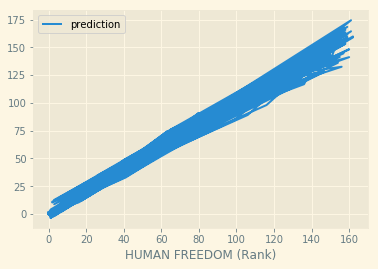

In [24]:
# Convert the Pyspark contructed dataframe to Pandas dataframe to visualize
lr_predictionsPandas = lr_predictions.toPandas()

plt.style.use('Solarize_Light2')
lr_predictionsPandas.plot(x="HUMAN FREEDOM (Rank)" ,y='prediction')

In [25]:
lr_predictions.describe().show()

+-------+--------------------+-------------------+
|summary|HUMAN FREEDOM (Rank)|         prediction|
+-------+--------------------+-------------------+
|  count|                1569|               1569|
|   mean|   75.75780752071383|  75.75780752071385|
| stddev|   45.59914326627794|   45.4004174123533|
|    min|                   0|-3.4880485366292078|
|    max|                 162| 174.37495033849646|
+-------+--------------------+-------------------+



In [26]:
lr_predictions.show()

+--------------------+--------------------+------------------+
|            features|HUMAN FREEDOM (Rank)|        prediction|
+--------------------+--------------------+------------------+
|[2017.0,5.2917516...|                  38| 35.51632876285382|
|[2017.0,3.7960803...|                 155|162.21448558672367|
|[2017.0,3.4119028...|                 151| 142.5681375057687|
|[2017.0,5.7447910...|                  77| 82.33736360342365|
|[2017.0,4.9326094...|                  54| 51.28203368761237|
|[2017.0,7.7762787...|                   5| 6.857864998503004|
|[2017.0,8.1717488...|                  13| 12.03636569148486|
|[2017.0,4.2912703...|                 121|120.93160281090022|
|[2017.0,6.4007902...|                  48| 46.98011652315458|
|[2017.0,5.8980375...|                  95|100.84912419573917|
|[2017.0,3.1328924...|                 138|137.08089058013255|
|[2017.0,6.6992874...|                  66| 75.93975032477809|
|[2017.0,5.1289249...|                  92| 92.34371955

In [27]:
train_data.describe().show()

+-------+--------------------+
|summary|HUMAN FREEDOM (Rank)|
+-------+--------------------+
|  count|                1243|
|   mean|   75.09734513274336|
| stddev|   45.46075815908157|
|    min|                   0|
|    max|                 162|
+-------+--------------------+



In [28]:
test_results = lr_model.evaluate(test_data)
print("RMSE on test data: " + str(test_results.rootMeanSquaredError))
print("R2 on test data: " + str(test_results.r2))

RMSE on test data: 4.400142077363856
R2 on test data: 0.9908642568221222
